# fvGP comprehensive test

## (0) Setup

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from fvgp.gp import GP
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


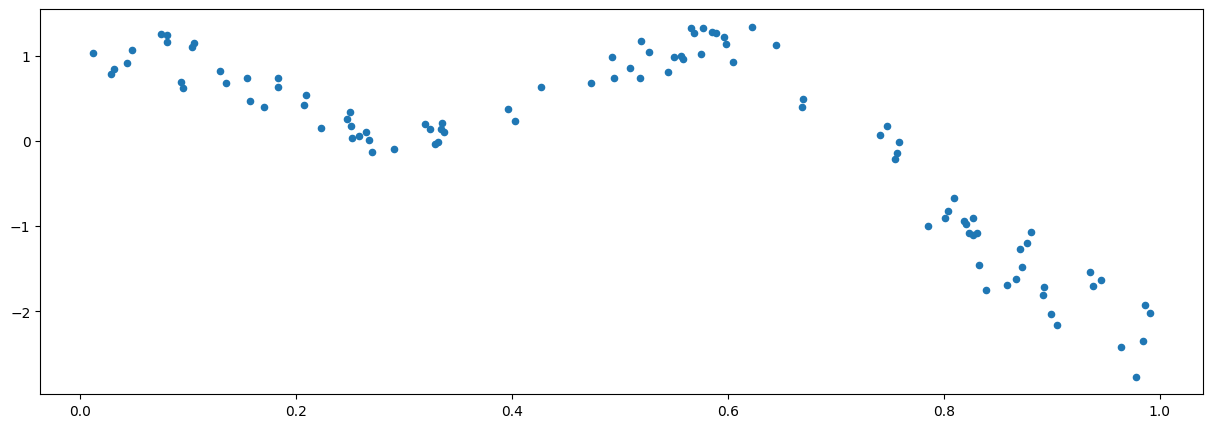

In [214]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)

#x_data = np.load("x_data.npy") 
x_data = np.random.rand(100)
#y_data = np.load("y_data.npy") 
y_data = f1(x_data) + (np.random.rand(len(x_data))-0.5) * 0.5



plt.figure(figsize = (15,5))

plt.scatter(x_data,y_data, s = 20)

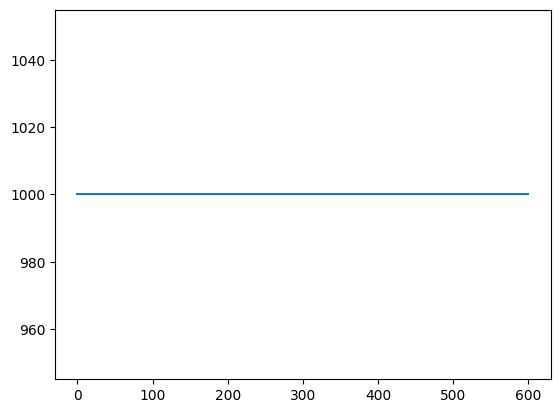

In [215]:
def s(x, my_slope, my_pow, my_intercept):
    o = np.exp(my_slope * (x-my_pow)/600.) + my_intercept
    
    return np.zeros((len(x),1)) + 1000.0


x = np.linspace(0,600,1000)
plt.plot(x,s(x,6.56645290e+00, -2.41247972e+02,1.81827292e+00))
plt.show()


def my_noise(x,hps,obj):
    my_slope = hps[2]
    my_pow = hps[3]
    my_intercept = hps[4]
    my_s = s(x,my_slope,my_pow,my_intercept)
    noise = np.diag(my_s[:,0])
    return noise

#stationary
def skernel(x1,x2,hps,obj):
    d = obj._get_distance_matrix(x1,x2)
    return hps[0] * obj.matern_kernel_diff1(d,hps[1])


#def meanf(x, hps, obj):
#    #print(np.sin(hps[3] * x))
#    return np.sin(hps[3] * x)[:,0]
#plt.figure(figsize = (15,5))
#plt.plot(x,meanf(x, np.array([1.,1.,5.0]), None), color = 'orange', label = 'task1')

Data Plot:


/tmp/ipykernel_2798202/3317229478.py:1: UserWarning: No noise function or measurement noise provided. Noise variances will be set to 1% of mean(y_data).
  my_gp1 = GP(1, x_data,y_data,


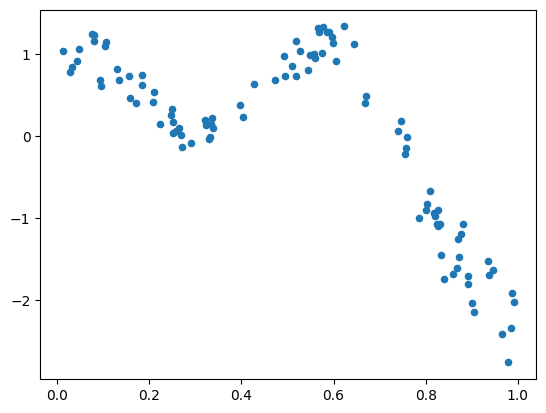

In [216]:
my_gp1 = GP(1, x_data,y_data,
            init_hyperparameters = np.ones((2)),
            #noise_variances=np.ones(y_data.shape) * 10., 
            compute_device='cpu', 
            gp_kernel_function=skernel, 
            gp_kernel_function_grad=None, 
            #gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            #gp_noise_function=my_noise,
            normalize_y=False,
            sparse_mode=False,
            gp2Scale = False,
            store_inv=False, 
            ram_economy=False, 
            args=None,
            )


print("Data Plot:")
plt.scatter(my_gp1.x_data,my_gp1.y_data, s = 20)
plt.show()


hps_bounds = np.array([[0.01,10.],
                       [0.01,10.],
                       #[1.0,10.], #slope
                       #[-300.,300.], #pow
                       #[0.1,100.]
                      ]) #intercept

#my_gp1.update_gp_data(x_data, y_data)
#print("Standard Training")
my_gp1.train(hps_bounds)


#print("Global Training")
#my_gp1.train(hps_bounds, method='global')
#print("hps: ", my_gp1.get_hyperparameters())
#print("Local Training")
#my_gp1.train(hps_bounds, method='local')
#print(my_gp1.get_hyperparameters())
#print("MCMC Training")
#my_gp1.train(hps_bounds, method='mcmc', max_iter=1000)
#print(my_gp1.get_hyperparameters())
#my_gp1.train(hps_bounds, method='hgdl')


In [217]:
#my_gp1.test_log_likelihood_gradient(np.array([100.,100.]))

In [218]:
#my_gp1.train(hps_bounds, method='hgdl', max_iter = 5)

In [219]:
#opt_obj = my_gp1.train_async(hps_bounds)

In [220]:
#my_gp1.update_hyperparameters(opt_obj)
#for entry in opt_obj.optima.list:
#    print(entry)
#    print("")

#my_gp1.entropy(my_gp1.prior_covariance)

In [221]:
#my_gp1.hyperparameters

In [222]:
#my_gp1.V

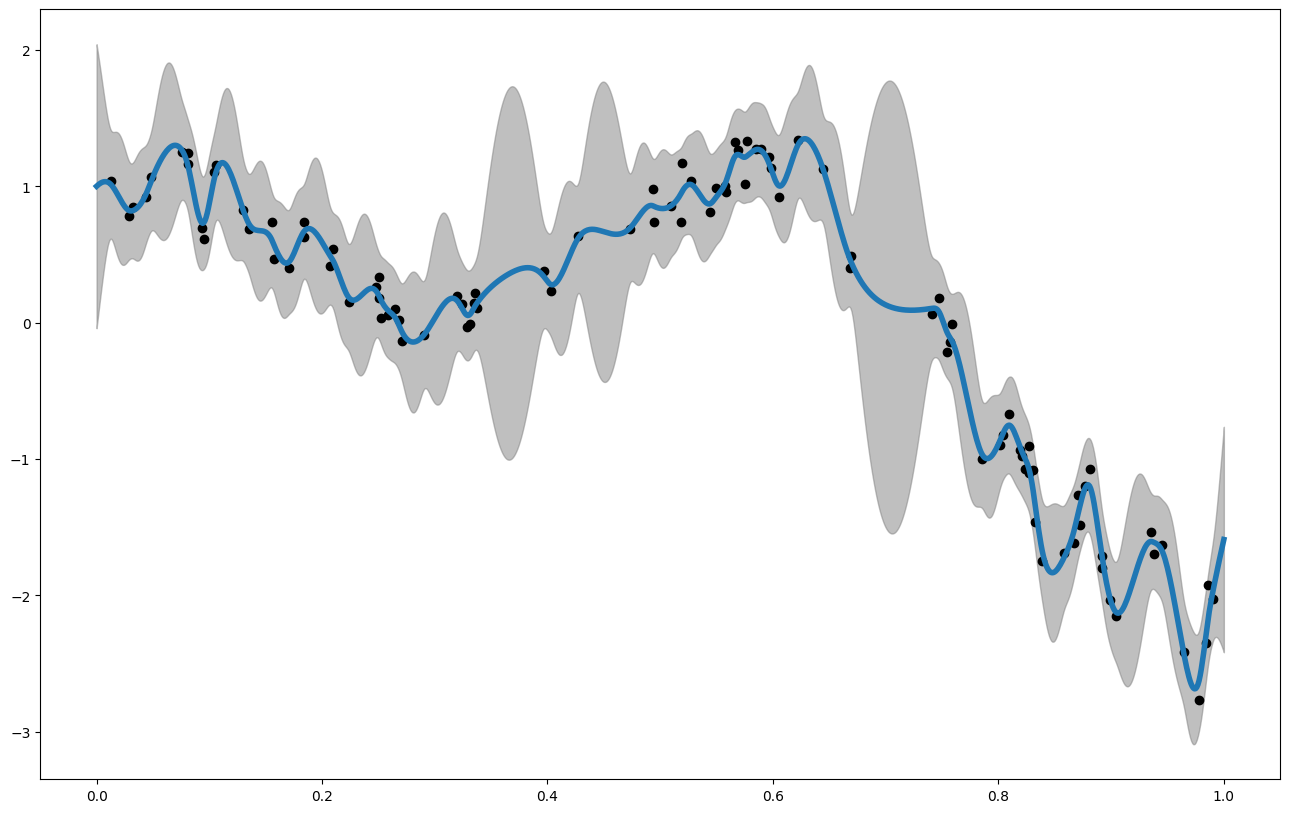

In [223]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
#plt.plot(x_pred,f1(x), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
#plt.plot(x, (f(x)-mean1)**2)
plt.scatter(x_data,y_data, color = 'black')
#plt.legend(fontsize = 20)

#print("error: ", np.sum(f1(x)-mean1)**2 / len(mean1))

In [224]:
x_pred = np.linspace(0,1,1000)

sig1 = np.zeros((len(x_pred)))
sig2 = np.zeros((len(x_pred)))
for i in range(len(x_pred)):
    print(x_pred[i:i+1].reshape(-1,1))
    sig1[i] = my_gp1._ig(x_pred[i:i+1].reshape(-1,1))
    sig2[i] = my_gp1.shannon_information_gain(x_pred[i:i+1].reshape(-1,1))["sig"]
    print("")
sig3 =  my_gp1.shannon_information_gain_vec(x_pred.reshape(-1,1))["sig(x)"]

[[0.]]

[[0.001001]]

[[0.002002]]

[[0.003003]]

[[0.004004]]

[[0.00500501]]

[[0.00600601]]

[[0.00700701]]

[[0.00800801]]

[[0.00900901]]

[[0.01001001]]

[[0.01101101]]

[[0.01201201]]

[[0.01301301]]

[[0.01401401]]

[[0.01501502]]

[[0.01601602]]

[[0.01701702]]

[[0.01801802]]

[[0.01901902]]

[[0.02002002]]

[[0.02102102]]

[[0.02202202]]

[[0.02302302]]

[[0.02402402]]

[[0.02502503]]

[[0.02602603]]

[[0.02702703]]

[[0.02802803]]

[[0.02902903]]

[[0.03003003]]

[[0.03103103]]

[[0.03203203]]

[[0.03303303]]

[[0.03403403]]

[[0.03503504]]

[[0.03603604]]

[[0.03703704]]

[[0.03803804]]

[[0.03903904]]

[[0.04004004]]

[[0.04104104]]

[[0.04204204]]

[[0.04304304]]

[[0.04404404]]

[[0.04504505]]

[[0.04604605]]

[[0.04704705]]

[[0.04804805]]

[[0.04904905]]

[[0.05005005]]

[[0.05105105]]

[[0.05205205]]

[[0.05305305]]

[[0.05405405]]

[[0.05505506]]

[[0.05605606]]

[[0.05705706]]

[[0.05805806]]

[[0.05905906]]

[[0.06006006]]

[[0.06106106]]

[[0.06206206]]

[[0.0630


[[0.52952953]]

[[0.53053053]]

[[0.53153153]]

[[0.53253253]]

[[0.53353353]]

[[0.53453453]]

[[0.53553554]]

[[0.53653654]]

[[0.53753754]]

[[0.53853854]]

[[0.53953954]]

[[0.54054054]]

[[0.54154154]]

[[0.54254254]]

[[0.54354354]]

[[0.54454454]]

[[0.54554555]]

[[0.54654655]]

[[0.54754755]]

[[0.54854855]]

[[0.54954955]]

[[0.55055055]]

[[0.55155155]]

[[0.55255255]]

[[0.55355355]]

[[0.55455455]]

[[0.55555556]]

[[0.55655656]]

[[0.55755756]]

[[0.55855856]]

[[0.55955956]]

[[0.56056056]]

[[0.56156156]]

[[0.56256256]]

[[0.56356356]]

[[0.56456456]]

[[0.56556557]]

[[0.56656657]]

[[0.56756757]]

[[0.56856857]]

[[0.56956957]]

[[0.57057057]]

[[0.57157157]]

[[0.57257257]]

[[0.57357357]]

[[0.57457457]]

[[0.57557558]]

[[0.57657658]]

[[0.57757758]]

[[0.57857858]]

[[0.57957958]]

[[0.58058058]]

[[0.58158158]]

[[0.58258258]]

[[0.58358358]]

[[0.58458458]]

[[0.58558559]]

[[0.58658659]]

[[0.58758759]]

[[0.58858859]]

[[0.58958959]]

[[0.59059059]]

[[0.591

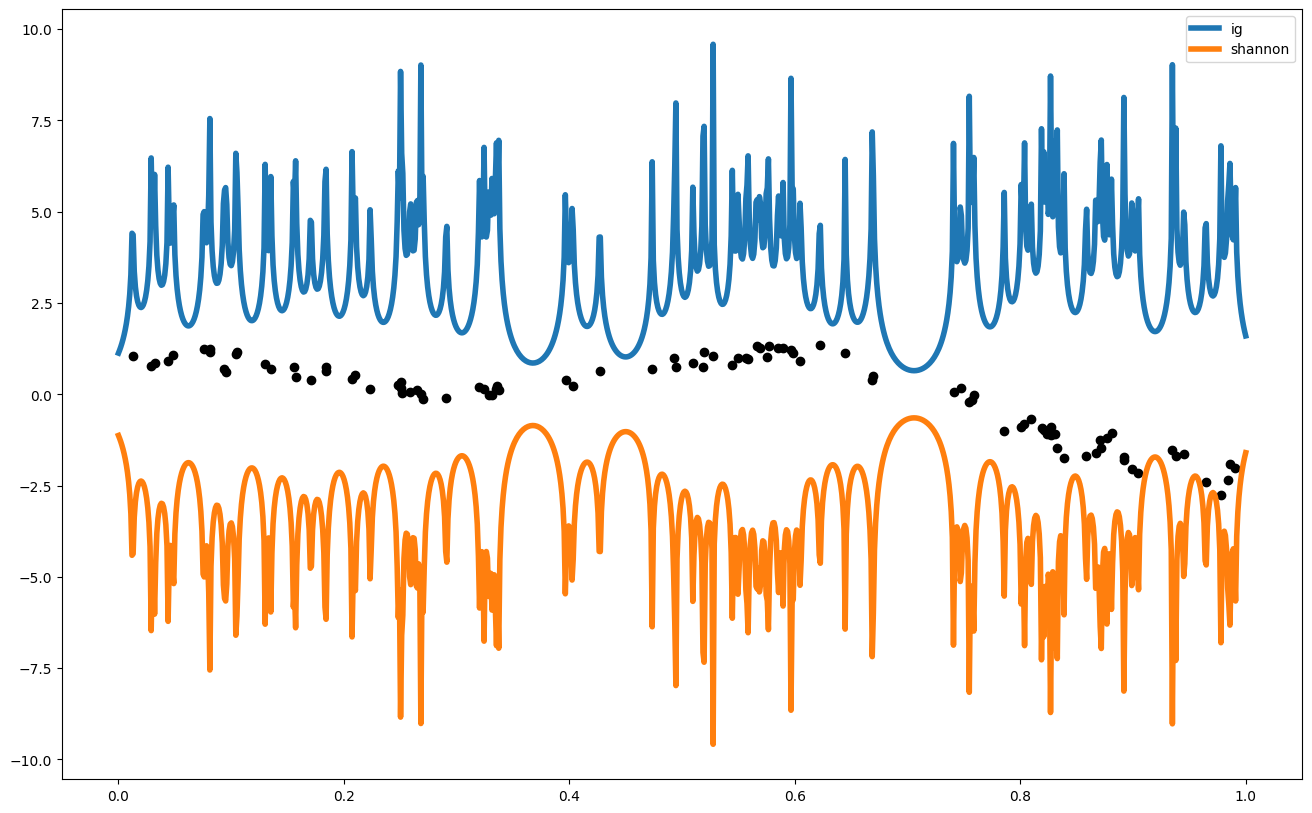

In [226]:
#print(sig3)
plt.figure(figsize = (16,10))
plt.plot(x_pred,sig1, label = "ig", linewidth = 4)
plt.plot(x_pred,sig3, label = "shannon", linewidth = 4)
plt.scatter(x_data,y_data, color = 'black')
plt.legend()

In [140]:
res = np.zeros((1000,2))
for i in range(1000):
    S =  my_gp1.posterior_covariance(x_pred.reshape(-1,1))["S"]
    entropy1 = my_gp1.entropy(S)
    print("current entropy before new point: ", )
    new_x = np.random.rand()
    sig = my_gp1.shannon_information_gain(np.array([[new_x]]))
    print("projected entropy decline: ", sig)
    my_gp1.update_gp_data(np.row_stack([my_gp1.x_data,np.array([[new_x]])]),np.append(my_gp1.y_data,f1(new_x)))
    S =  my_gp1.posterior_covariance(x_pred.reshape(-1,1))["S"]
    entropy2 = my_gp1.entropy(S)
    print("entropy after: ", entropy2)
    print("entropy difference vs sig: ", entropy2 - entropy1, sig["sig"])
    res[i] = np.array([entropy2 - entropy1, sig["sig"]])
    print("")

current entropy before new point: 
projected entropy decline:  {'x': array([[0.36558968]]), 'prior entropy': -1040.9844952578937, 'joint entropy': -1044.6742671097943, 'sig': -3.6897718519005593}
entropy after:  -3289.4623743454126
entropy difference vs sig:  -0.22258819794842566 -3.6897718519005593

current entropy before new point: 
projected entropy decline:  {'x': array([[0.60213807]]), 'prior entropy': -1044.6742671097943, 'joint entropy': -1048.1401901997301, 'sig': -3.4659230899358136}
entropy after:  -3289.5971290355515
entropy difference vs sig:  -0.13475469013883412 -3.4659230899358136

current entropy before new point: 
projected entropy decline:  {'x': array([[0.27058489]]), 'prior entropy': -1048.1401901997301, 'joint entropy': -1051.7601864811304, 'sig': -3.61999628140029}
entropy after:  -3289.851720623991
entropy difference vs sig:  -0.2545915884393253 -3.61999628140029

current entropy before new point: 
projected entropy decline:  {'x': array([[0.56948557]]), 'prior e

current entropy before new point: 
projected entropy decline:  {'x': array([[0.59320151]]), 'prior entropy': -1147.4926227367644, 'joint entropy': -1152.0829585666013, 'sig': -4.590335829836931}
entropy after:  -3293.5333979738775
entropy difference vs sig:  -0.04849812491738703 -4.590335829836931

current entropy before new point: 
projected entropy decline:  {'x': array([[0.27114921]]), 'prior entropy': -1152.0829585666013, 'joint entropy': -1157.8639480398417, 'sig': -5.780989473240425}
entropy after:  -3293.7367041500906
entropy difference vs sig:  -0.2033061762131183 -5.780989473240425

current entropy before new point: 
projected entropy decline:  {'x': array([[0.2067537]]), 'prior entropy': -1157.8639480398417, 'joint entropy': -1161.7174169266593, 'sig': -3.853468886817609}
entropy after:  -3293.919901645367
entropy difference vs sig:  -0.18319749527654494 -3.853468886817609

current entropy before new point: 
projected entropy decline:  {'x': array([[0.05361754]]), 'prior entr

entropy after:  -3298.174660415993
entropy difference vs sig:  -0.17843683397586574 -3.9596946374595063

current entropy before new point: 
projected entropy decline:  {'x': array([[0.36139509]]), 'prior entropy': -1252.9776793555213, 'joint entropy': -1257.8441042519971, 'sig': -4.866424896475792}
entropy after:  -3298.346028525292
entropy difference vs sig:  -0.17136810929878266 -4.866424896475792

current entropy before new point: 
projected entropy decline:  {'x': array([[0.35927163]]), 'prior entropy': -1257.8441042519971, 'joint entropy': -1263.0754872811199, 'sig': -5.231383029122753}
entropy after:  -3298.4994220729354
entropy difference vs sig:  -0.15339354764364543 -5.231383029122753

current entropy before new point: 
projected entropy decline:  {'x': array([[0.38860677]]), 'prior entropy': -1263.0754872811199, 'joint entropy': -1267.30870905976, 'sig': -4.2332217786402}
entropy after:  -3298.709256583869
entropy difference vs sig:  -0.2098345109334332 -4.2332217786402

curr

current entropy before new point: 
projected entropy decline:  {'x': array([[0.83016813]]), 'prior entropy': -1368.1093682631724, 'joint entropy': -1376.4020761770541, 'sig': -8.292707913881713}
entropy after:  -3302.242198053325
entropy difference vs sig:  -0.0060601455052164965 -8.292707913881713

current entropy before new point: 
projected entropy decline:  {'x': array([[0.75304552]]), 'prior entropy': -1376.4020761770541, 'joint entropy': -1382.6224860630357, 'sig': -6.220409885981553}
entropy after:  -3302.4329643415535
entropy difference vs sig:  -0.19076628822858765 -6.220409885981553

current entropy before new point: 
projected entropy decline:  {'x': array([[0.3361123]]), 'prior entropy': -1382.6224860630357, 'joint entropy': -1386.8813276018916, 'sig': -4.258841538855904}
entropy after:  -3302.6163901325476
entropy difference vs sig:  -0.18342579099407885 -4.258841538855904

current entropy before new point: 
projected entropy decline:  {'x': array([[0.59755714]]), 'prior e

entropy after:  -3305.5143826744775
entropy difference vs sig:  -0.06503464030265604 -2.396446097430726

current entropy before new point: 
projected entropy decline:  {'x': array([[0.86289541]]), 'prior entropy': -1473.4686455642816, 'joint entropy': -1479.5511631536187, 'sig': -6.082517589337158}
entropy after:  -3305.484444104333
entropy difference vs sig:  0.029938570144622645 -6.082517589337158

current entropy before new point: 
projected entropy decline:  {'x': array([[0.45213361]]), 'prior entropy': -1479.5511631536187, 'joint entropy': -1482.234535296745, 'sig': -2.6833721431262347}
entropy after:  -3305.713105621546
entropy difference vs sig:  -0.22866151721336792 -2.6833721431262347

current entropy before new point: 
projected entropy decline:  {'x': array([[0.55247257]]), 'prior entropy': -1482.234535296745, 'joint entropy': -1487.4871258354124, 'sig': -5.252590538667391}
entropy after:  -3305.763814665063
entropy difference vs sig:  -0.050709043516690144 -5.25259053866739

entropy after:  -3310.1120014894136
entropy difference vs sig:  -0.45719784542234265 -1.3009892875006699

current entropy before new point: 
projected entropy decline:  {'x': array([[0.88290435]]), 'prior entropy': -1594.124546152213, 'joint entropy': -1601.352360613651, 'sig': -7.227814461437902}
entropy after:  -3310.123291464381
entropy difference vs sig:  -0.011289974967439775 -7.227814461437902

current entropy before new point: 
projected entropy decline:  {'x': array([[0.3334672]]), 'prior entropy': -1601.352360613651, 'joint entropy': -1605.754913571603, 'sig': -4.402552957952139}
entropy after:  -3310.324483181494
entropy difference vs sig:  -0.20119171711303352 -4.402552957952139

current entropy before new point: 
projected entropy decline:  {'x': array([[0.26564791]]), 'prior entropy': -1605.754913571603, 'joint entropy': -1608.9650327429604, 'sig': -3.2101191713572916}
entropy after:  -3310.560652317467
entropy difference vs sig:  -0.23616913597288658 -3.2101191713572916



entropy after:  -3314.14709945991
entropy difference vs sig:  -0.19010312572936527 -5.0090393503633095

current entropy before new point: 
projected entropy decline:  {'x': array([[0.23779388]]), 'prior entropy': -1707.6077068250543, 'joint entropy': -1710.5124140376556, 'sig': -2.904707212601352}
entropy after:  -3314.360109039066
entropy difference vs sig:  -0.21300957915627805 -2.904707212601352

current entropy before new point: 
projected entropy decline:  {'x': array([[0.25298583]]), 'prior entropy': -1710.5124140376556, 'joint entropy': -1713.647969544556, 'sig': -3.135555506900346}
entropy after:  -3314.6027204950783
entropy difference vs sig:  -0.24261145601212775 -3.135555506900346

current entropy before new point: 
projected entropy decline:  {'x': array([[0.89576797]]), 'prior entropy': -1713.647969544556, 'joint entropy': -1718.1150778861668, 'sig': -4.46710834161081}
entropy after:  -3314.5601341219703
entropy difference vs sig:  0.04258637310795166 -4.46710834161081

cu

entropy after:  -3317.631751943713
entropy difference vs sig:  -0.07781463010996958 -5.97170370234835

current entropy before new point: 
projected entropy decline:  {'x': array([[0.43160633]]), 'prior entropy': -1842.8015416478713, 'joint entropy': -1847.0871355748807, 'sig': -4.285593927009359}
entropy after:  -3317.802468632986
entropy difference vs sig:  -0.17071668927292194 -4.285593927009359

current entropy before new point: 
projected entropy decline:  {'x': array([[0.85215088]]), 'prior entropy': -1847.0871355748807, 'joint entropy': -1852.7467443962141, 'sig': -5.65960882133345}
entropy after:  -3317.7878064590436
entropy difference vs sig:  0.014662173942269874 -5.65960882133345

current entropy before new point: 
projected entropy decline:  {'x': array([[0.21993378]]), 'prior entropy': -1852.7467443962141, 'joint entropy': -1856.4309352228092, 'sig': -3.6841908265951133}
entropy after:  -3317.955804939413
entropy difference vs sig:  -0.16799848036953335 -3.6841908265951133


entropy after:  -3321.0438363501075
entropy difference vs sig:  -0.09916492304910207 -4.319867144336058

current entropy before new point: 
projected entropy decline:  {'x': array([[0.84096903]]), 'prior entropy': -1975.150631525335, 'joint entropy': -1981.02399579453, 'sig': -5.873364269195008}
entropy after:  -3321.002841465692
entropy difference vs sig:  0.04099488441534049 -5.873364269195008

current entropy before new point: 
projected entropy decline:  {'x': array([[0.09592585]]), 'prior entropy': -1981.02399579453, 'joint entropy': -1985.2986049577007, 'sig': -4.27460916317068}
entropy after:  -3321.079689514149
entropy difference vs sig:  -0.07684804845666804 -4.27460916317068

current entropy before new point: 
projected entropy decline:  {'x': array([[0.04413046]]), 'prior entropy': -1985.2986049577007, 'joint entropy': -1990.1460372110841, 'sig': -4.847432253383431}
entropy after:  -3321.145009041354
entropy difference vs sig:  -0.06531952720524714 -4.847432253383431

curren

entropy after:  -3323.4651499256747
entropy difference vs sig:  -0.17409124476853322 -3.485447180315532

current entropy before new point: 
projected entropy decline:  {'x': array([[0.81451606]]), 'prior entropy': -2103.820487369561, 'joint entropy': -2107.311946015578, 'sig': -3.491458646017236}
entropy after:  -3323.5793876073717
entropy difference vs sig:  -0.11423768169697723 -3.491458646017236

current entropy before new point: 
projected entropy decline:  {'x': array([[0.88272136]]), 'prior entropy': -2107.311946015578, 'joint entropy': -2113.8963769084335, 'sig': -6.58443089285538}
entropy after:  -3323.5831875944864
entropy difference vs sig:  -0.0037999871146894293 -6.58443089285538

current entropy before new point: 
projected entropy decline:  {'x': array([[0.13823652]]), 'prior entropy': -2113.8963769084335, 'joint entropy': -2116.2870874127952, 'sig': -2.3907105043617776}
entropy after:  -3323.7866989848785
entropy difference vs sig:  -0.20351139039212285 -2.39071050436177

entropy after:  -3326.35760004137
entropy difference vs sig:  -0.18449845221584837 -4.05487128463119

current entropy before new point: 
projected entropy decline:  {'x': array([[0.46496148]]), 'prior entropy': -2233.943413451331, 'joint entropy': -2236.9964169585533, 'sig': -3.0530035072224564}
entropy after:  -3326.512307886546
entropy difference vs sig:  -0.15470784517583525 -3.0530035072224564

current entropy before new point: 
projected entropy decline:  {'x': array([[0.82596345]]), 'prior entropy': -2236.9964169585533, 'joint entropy': -2243.5178230733345, 'sig': -6.521406114781257}
entropy after:  -3326.550108300779
entropy difference vs sig:  -0.03780041423306102 -6.521406114781257

current entropy before new point: 
projected entropy decline:  {'x': array([[0.2489798]]), 'prior entropy': -2243.5178230733345, 'joint entropy': -2249.839590768005, 'sig': -6.321767694670598}
entropy after:  -3326.7019323118852
entropy difference vs sig:  -0.15182401110632782 -6.321767694670598

c

entropy after:  -3328.8527289394438
entropy difference vs sig:  -0.1434899823707383 -4.444813612952203

current entropy before new point: 
projected entropy decline:  {'x': array([[0.53931757]]), 'prior entropy': -2370.4319127273848, 'joint entropy': -2374.2599211560237, 'sig': -3.8280084286388956}
entropy after:  -3328.9833086652375
entropy difference vs sig:  -0.1305797257937229 -3.8280084286388956

current entropy before new point: 
projected entropy decline:  {'x': array([[0.42399334]]), 'prior entropy': -2374.2599211560237, 'joint entropy': -2381.0757700659087, 'sig': -6.815848909885062}
entropy after:  -3329.103954046994
entropy difference vs sig:  -0.12064538175673079 -6.815848909885062

current entropy before new point: 
projected entropy decline:  {'x': array([[0.83490339]]), 'prior entropy': -2381.0757700659087, 'joint entropy': -2386.5322637256677, 'sig': -5.456493659758962}
entropy after:  -3329.1130219008905
entropy difference vs sig:  -0.009067853896340239 -5.456493659758

entropy after:  -3331.4650022742585
entropy difference vs sig:  -0.0700369582455096 -6.355032731702067

current entropy before new point: 
projected entropy decline:  {'x': array([[0.78073575]]), 'prior entropy': -2496.803754931473, 'joint entropy': -2502.1521903098364, 'sig': -5.34843537836332}
entropy after:  -3331.5327511014816
entropy difference vs sig:  -0.06774882722311304 -5.34843537836332

current entropy before new point: 
projected entropy decline:  {'x': array([[0.1335332]]), 'prior entropy': -2502.1521903098364, 'joint entropy': -2505.742600983798, 'sig': -3.590410673961742}
entropy after:  -3331.6128077636063
entropy difference vs sig:  -0.08005666212466167 -3.590410673961742

current entropy before new point: 
projected entropy decline:  {'x': array([[0.77482584]]), 'prior entropy': -2505.742600983798, 'joint entropy': -2508.605797889578, 'sig': -2.8631969057796596}
entropy after:  -3331.7344421086923
entropy difference vs sig:  -0.12163434508602222 -2.8631969057796596

c

entropy after:  -3333.824976092956
entropy difference vs sig:  -0.12118029911653139 -5.687698277766231

current entropy before new point: 
projected entropy decline:  {'x': array([[0.7166019]]), 'prior entropy': -2631.0351212853475, 'joint entropy': -2635.0647887314913, 'sig': -4.029667446143776}
entropy after:  -3334.026265760716
entropy difference vs sig:  -0.20128966775973822 -4.029667446143776

current entropy before new point: 
projected entropy decline:  {'x': array([[0.35576033]]), 'prior entropy': -2635.0647887314913, 'joint entropy': -2641.029509780612, 'sig': -5.964721049120726}
entropy after:  -3334.148303487779
entropy difference vs sig:  -0.12203772706288873 -5.964721049120726

current entropy before new point: 
projected entropy decline:  {'x': array([[0.97365145]]), 'prior entropy': -2641.029509780612, 'joint entropy': -2646.187003334639, 'sig': -5.157493554027042}
entropy after:  -3334.087556553099
entropy difference vs sig:  0.060746934679627884 -5.157493554027042

cur

entropy after:  -3336.0275889610116
entropy difference vs sig:  -0.0004076232844454353 -6.123073438035135

current entropy before new point: 
projected entropy decline:  {'x': array([[0.68406808]]), 'prior entropy': -2773.054100914939, 'joint entropy': -2776.489561214983, 'sig': -3.4354603000438146}
entropy after:  -3336.1829139920724
entropy difference vs sig:  -0.15532503106078366 -3.4354603000438146

current entropy before new point: 
projected entropy decline:  {'x': array([[0.79131306]]), 'prior entropy': -2776.489561214983, 'joint entropy': -2781.8156920208985, 'sig': -5.326130805915454}
entropy after:  -3336.2915497059116
entropy difference vs sig:  -0.10863571383924864 -5.326130805915454

current entropy before new point: 
projected entropy decline:  {'x': array([[0.22961997]]), 'prior entropy': -2781.8156920208985, 'joint entropy': -2785.81284822998, 'sig': -3.9971562090813677}
entropy after:  -3336.434979713526
entropy difference vs sig:  -0.14343000761436997 -3.9971562090813

entropy after:  -3338.4933757949325
entropy difference vs sig:  -0.1414251508513189 -8.037826202233191

current entropy before new point: 
projected entropy decline:  {'x': array([[0.83735317]]), 'prior entropy': -2916.7566480840333, 'joint entropy': -2922.745213221097, 'sig': -5.988565137063688}
entropy after:  -3338.480238715963
entropy difference vs sig:  0.013137078969521099 -5.988565137063688

current entropy before new point: 
projected entropy decline:  {'x': array([[0.33809931]]), 'prior entropy': -2922.745213221097, 'joint entropy': -2927.533308543901, 'sig': -4.788095322804111}
entropy after:  -3338.612319421511
entropy difference vs sig:  -0.13208070554810547 -4.788095322804111

current entropy before new point: 
projected entropy decline:  {'x': array([[0.38799468]]), 'prior entropy': -2927.533308543901, 'joint entropy': -2935.199549275892, 'sig': -7.666240731990911}
entropy after:  -3338.7536154730183
entropy difference vs sig:  -0.14129605150719726 -7.666240731990911

cur

entropy after:  -3340.634032444414
entropy difference vs sig:  -0.15604684510526567 -5.966015326099296

current entropy before new point: 
projected entropy decline:  {'x': array([[0.20461364]]), 'prior entropy': -3065.1901602187468, 'joint entropy': -3070.3674032476797, 'sig': -5.177243028932935}
entropy after:  -3340.7508317289744
entropy difference vs sig:  -0.1167992845603294 -5.177243028932935

current entropy before new point: 
projected entropy decline:  {'x': array([[0.09377559]]), 'prior entropy': -3070.3674032476797, 'joint entropy': -3075.736582695585, 'sig': -5.369179447905481}
entropy after:  -3340.8304854770254
entropy difference vs sig:  -0.0796537480509869 -5.369179447905481

current entropy before new point: 
projected entropy decline:  {'x': array([[0.27491172]]), 'prior entropy': -3075.736582695585, 'joint entropy': -3079.699331773893, 'sig': -3.962749078307752}
entropy after:  -3340.974928950511
entropy difference vs sig:  -0.14444347348580777 -3.962749078307752

cu

entropy after:  -3343.1137726766997
entropy difference vs sig:  -0.08586714385182859 -4.324903419794282

current entropy before new point: 
projected entropy decline:  {'x': array([[0.30189911]]), 'prior entropy': -3213.9767785069093, 'joint entropy': -3218.964063788278, 'sig': -4.987285281368713}
entropy after:  -3343.261449650629
entropy difference vs sig:  -0.14767697392926493 -4.987285281368713

current entropy before new point: 
projected entropy decline:  {'x': array([[0.93570835]]), 'prior entropy': -3218.964063788278, 'joint entropy': -3224.567297261064, 'sig': -5.603233472786087}
entropy after:  -3343.2538214375786
entropy difference vs sig:  0.0076282130503386725 -5.603233472786087

current entropy before new point: 
projected entropy decline:  {'x': array([[0.08609729]]), 'prior entropy': -3224.567297261064, 'joint entropy': -3231.677988995967, 'sig': -7.110691734902957}
entropy after:  -3343.306493594228
entropy difference vs sig:  -0.052672156649350654 -7.110691734902957



entropy after:  -3344.8303698633986
entropy difference vs sig:  -0.04692633665854373 -4.89632518627559

current entropy before new point: 
projected entropy decline:  {'x': array([[0.14640617]]), 'prior entropy': -3366.331561429889, 'joint entropy': -3376.1329399479955, 'sig': -9.801378518106503}
entropy after:  -3344.91238535649
entropy difference vs sig:  -0.08201549309160328 -9.801378518106503

current entropy before new point: 
projected entropy decline:  {'x': array([[0.10967873]]), 'prior entropy': -3376.1329399479955, 'joint entropy': -3381.373586371442, 'sig': -5.240646423446378}
entropy after:  -3344.954834752871
entropy difference vs sig:  -0.04244939638101641 -5.240646423446378

current entropy before new point: 
projected entropy decline:  {'x': array([[0.10860407]]), 'prior entropy': -3381.373586371442, 'joint entropy': -3386.672426831675, 'sig': -5.298840460232896}
entropy after:  -3344.9895104983993
entropy difference vs sig:  -0.03467574552814767 -5.298840460232896

cur

entropy after:  -3346.297768015697
entropy difference vs sig:  -0.01552775101208681 -5.200935297675642

current entropy before new point: 
projected entropy decline:  {'x': array([[0.7535965]]), 'prior entropy': -3518.849242203093, 'joint entropy': -3523.3786148970885, 'sig': -4.529372693995356}
entropy after:  -3346.4211550066398
entropy difference vs sig:  -0.1233869909428904 -4.529372693995356

current entropy before new point: 
projected entropy decline:  {'x': array([[0.81459701]]), 'prior entropy': -3523.3786148970885, 'joint entropy': -3529.7389157507278, 'sig': -6.3603008536392736}
entropy after:  -3346.4999242831987
entropy difference vs sig:  -0.07876927655888721 -6.3603008536392736

current entropy before new point: 
projected entropy decline:  {'x': array([[0.53063368]]), 'prior entropy': -3529.7389157507278, 'joint entropy': -3532.6616745520896, 'sig': -2.9227588013618515}
entropy after:  -3346.6116650640693
entropy difference vs sig:  -0.1117407808706048 -2.92275880136185

entropy after:  -3348.510630205196
entropy difference vs sig:  -0.09407182566246775 -8.098956166457356

current entropy before new point: 
projected entropy decline:  {'x': array([[0.4851838]]), 'prior entropy': -3668.7437485304918, 'joint entropy': -3676.590088174551, 'sig': -7.846339644059299}
entropy after:  -3348.5596676110913
entropy difference vs sig:  -0.04903740589543304 -7.846339644059299

current entropy before new point: 
projected entropy decline:  {'x': array([[0.62768019]]), 'prior entropy': -3676.590088174551, 'joint entropy': -3680.719946562168, 'sig': -4.129858387616878}
entropy after:  -3348.6136682155325
entropy difference vs sig:  -0.05400060444117116 -4.129858387616878

current entropy before new point: 
projected entropy decline:  {'x': array([[0.43022453]]), 'prior entropy': -3680.719946562168, 'joint entropy': -3684.41299635464, 'sig': -3.693049792472266}
entropy after:  -3348.7420575240253
entropy difference vs sig:  -0.12838930849284225 -3.693049792472266

cur

projected entropy decline:  {'x': array([[0.95633696]]), 'prior entropy': -3816.1769496755123, 'joint entropy': -3820.302549906184, 'sig': -4.125600230671807}
entropy after:  -3350.685827592561
entropy difference vs sig:  -0.001358903966320213 -4.125600230671807

current entropy before new point: 
projected entropy decline:  {'x': array([[0.19602677]]), 'prior entropy': -3820.302549906184, 'joint entropy': -3827.416669893809, 'sig': -7.11411998762469}
entropy after:  -3350.763734994653
entropy difference vs sig:  -0.0779074020920234 -7.11411998762469

current entropy before new point: 
projected entropy decline:  {'x': array([[0.92246989]]), 'prior entropy': -3827.416669893809, 'joint entropy': -3832.5453179595625, 'sig': -5.128648065753623}
entropy after:  -3350.7384475747263
entropy difference vs sig:  0.02528741992682626 -5.128648065753623

current entropy before new point: 
projected entropy decline:  {'x': array([[0.2062283]]), 'prior entropy': -3832.5453179595625, 'joint entropy'

entropy after:  -3352.990958196299
entropy difference vs sig:  -0.12164564753402374 -3.836105837406649

current entropy before new point: 
projected entropy decline:  {'x': array([[0.89124178]]), 'prior entropy': -3977.2129140078277, 'joint entropy': -3984.0016470652617, 'sig': -6.788733057434001}
entropy after:  -3352.977462574007
entropy difference vs sig:  0.013495622291884501 -6.788733057434001

current entropy before new point: 
projected entropy decline:  {'x': array([[0.07927737]]), 'prior entropy': -3984.0016470652617, 'joint entropy': -3991.6861327926717, 'sig': -7.684485727409992}
entropy after:  -3353.045254838618
entropy difference vs sig:  -0.06779226461094368 -7.684485727409992

current entropy before new point: 
projected entropy decline:  {'x': array([[0.72465888]]), 'prior entropy': -3991.6861327926717, 'joint entropy': -3996.4358553601555, 'sig': -4.749722567483786}
entropy after:  -3353.184630336297
entropy difference vs sig:  -0.13937549767888413 -4.749722567483786


projected entropy decline:  {'x': array([[0.50096245]]), 'prior entropy': -4125.389644654332, 'joint entropy': -4129.4207214805665, 'sig': -4.031076826234312}
entropy after:  -3355.0551437997688
entropy difference vs sig:  -0.07716152381726715 -4.031076826234312

current entropy before new point: 
projected entropy decline:  {'x': array([[0.90015006]]), 'prior entropy': -4129.4207214805665, 'joint entropy': -4134.009110558809, 'sig': -4.588389078242471}
entropy after:  -3355.004408349038
entropy difference vs sig:  0.050735450730826415 -4.588389078242471

current entropy before new point: 
projected entropy decline:  {'x': array([[0.03481638]]), 'prior entropy': -4134.009110558809, 'joint entropy': -4139.130625527407, 'sig': -5.121514968597694}
entropy after:  -3355.0757895981355
entropy difference vs sig:  -0.07138124909761245 -5.121514968597694

current entropy before new point: 
projected entropy decline:  {'x': array([[0.40468384]]), 'prior entropy': -4139.130625527407, 'joint entr

current entropy before new point: 
projected entropy decline:  {'x': array([[0.93852157]]), 'prior entropy': -4280.158963993941, 'joint entropy': -4288.150333441068, 'sig': -7.991369447126999}
entropy after:  -3356.702709270467
entropy difference vs sig:  -0.021388107103121 -7.991369447126999

current entropy before new point: 
projected entropy decline:  {'x': array([[0.85809198]]), 'prior entropy': -4288.150333441068, 'joint entropy': -4294.409549944483, 'sig': -6.259216503414791}
entropy after:  -3356.6860784449223
entropy difference vs sig:  0.016630825544780237 -6.259216503414791

current entropy before new point: 
projected entropy decline:  {'x': array([[0.94897424]]), 'prior entropy': -4294.409549944483, 'joint entropy': -4301.828337754208, 'sig': -7.4187878097254725}
entropy after:  -3356.7023077440413
entropy difference vs sig:  -0.01622929911900428 -7.4187878097254725

current entropy before new point: 
projected entropy decline:  {'x': array([[0.5742766]]), 'prior entropy':

entropy after:  -3358.345540901521
entropy difference vs sig:  -0.03896929253187409 -4.940440492659036

current entropy before new point: 
projected entropy decline:  {'x': array([[0.19149098]]), 'prior entropy': -4437.080633921196, 'joint entropy': -4441.282047515368, 'sig': -4.201413594171754}
entropy after:  -3358.4326961940355
entropy difference vs sig:  -0.08715529251458065 -4.201413594171754

current entropy before new point: 
projected entropy decline:  {'x': array([[0.90025253]]), 'prior entropy': -4441.282047515368, 'joint entropy': -4447.584786276979, 'sig': -6.302738761611181}
entropy after:  -3358.38161980186
entropy difference vs sig:  0.05107639217567339 -6.302738761611181

current entropy before new point: 
projected entropy decline:  {'x': array([[0.68605603]]), 'prior entropy': -4447.584786276979, 'joint entropy': -4451.77399775452, 'sig': -4.189211477540994}
entropy after:  -3358.479761438591
entropy difference vs sig:  -0.09814163673127041 -4.189211477540994

current

entropy after:  -3360.1893443127015
entropy difference vs sig:  -0.1473248562642766 -5.45498638193385

current entropy before new point: 
projected entropy decline:  {'x': array([[0.34005978]]), 'prior entropy': -4590.1949125894225, 'joint entropy': -4596.480544792388, 'sig': -6.285632202965644}
entropy after:  -3360.298175673521
entropy difference vs sig:  -0.10883136081974953 -6.285632202965644

current entropy before new point: 
projected entropy decline:  {'x': array([[0.25065617]]), 'prior entropy': -4596.480544792388, 'joint entropy': -4602.852728257808, 'sig': -6.372183465419766}
entropy after:  -3360.4151562878474
entropy difference vs sig:  -0.11698061432616669 -6.372183465419766

current entropy before new point: 
projected entropy decline:  {'x': array([[0.92253253]]), 'prior entropy': -4602.852728257808, 'joint entropy': -4610.089414616523, 'sig': -7.2366863587149055}
entropy after:  -3360.3702652130946
entropy difference vs sig:  0.04489107475274068 -7.2366863587149055

cu

entropy after:  -3361.760473998626
entropy difference vs sig:  -0.045600052655572654 -6.2512429379357854

current entropy before new point: 
projected entropy decline:  {'x': array([[0.87815001]]), 'prior entropy': -4744.988417458252, 'joint entropy': -4750.7804844118855, 'sig': -5.792066953633366}
entropy after:  -3361.7866624386265
entropy difference vs sig:  -0.026188440000623814 -5.792066953633366

current entropy before new point: 
projected entropy decline:  {'x': array([[0.70102559]]), 'prior entropy': -4750.7804844118855, 'joint entropy': -4758.568301156459, 'sig': -7.78781674457332}
entropy after:  -3361.8589014432696
entropy difference vs sig:  -0.07223900464305189 -7.78781674457332

current entropy before new point: 
projected entropy decline:  {'x': array([[0.62094904]]), 'prior entropy': -4758.568301156459, 'joint entropy': -4767.831538494223, 'sig': -9.263237337764622}
entropy after:  -3361.9032857795587
entropy difference vs sig:  -0.04438433628911298 -9.263237337764622


entropy after:  -3363.2142316473914
entropy difference vs sig:  -0.10192336708314542 -6.261382425920601

current entropy before new point: 
projected entropy decline:  {'x': array([[0.9145725]]), 'prior entropy': -4904.2903557779655, 'joint entropy': -4909.2046199763445, 'sig': -4.914264198378987}
entropy after:  -3363.1665134961445
entropy difference vs sig:  0.04771815124695422 -4.914264198378987

current entropy before new point: 
projected entropy decline:  {'x': array([[0.71924875]]), 'prior entropy': -4909.2046199763445, 'joint entropy': -4913.627339603387, 'sig': -4.42271962704217}
entropy after:  -3363.291602740723
entropy difference vs sig:  -0.12508924457870307 -4.42271962704217

current entropy before new point: 
projected entropy decline:  {'x': array([[0.66786371]]), 'prior entropy': -4913.627339603387, 'joint entropy': -4922.0635900598645, 'sig': -8.436250456477865}
entropy after:  -3363.349909689958
entropy difference vs sig:  -0.058306949234975036 -8.436250456477865

cu

entropy after:  -3365.2414812509473
entropy difference vs sig:  -0.09673690190720663 -4.813415355662073

current entropy before new point: 
projected entropy decline:  {'x': array([[0.75225604]]), 'prior entropy': -5050.7040712098, 'joint entropy': -5057.234541981866, 'sig': -6.53047077206611}
entropy after:  -3365.3448910400334
entropy difference vs sig:  -0.10340978908607212 -6.53047077206611

current entropy before new point: 
projected entropy decline:  {'x': array([[0.5494147]]), 'prior entropy': -5057.234541981866, 'joint entropy': -5062.49753550885, 'sig': -5.262993526984246}
entropy after:  -3365.3912617712235
entropy difference vs sig:  -0.04637073119010893 -5.262993526984246

current entropy before new point: 
projected entropy decline:  {'x': array([[0.16865053]]), 'prior entropy': -5062.49753550885, 'joint entropy': -5069.849509351344, 'sig': -7.351973842493862}
entropy after:  -3365.4619060679265
entropy difference vs sig:  -0.07064429670299432 -7.351973842493862

current 

entropy after:  -3366.88500774442
entropy difference vs sig:  -0.05274660798477271 -6.867537082571289

current entropy before new point: 
projected entropy decline:  {'x': array([[0.81482411]]), 'prior entropy': -5217.264624707888, 'joint entropy': -5223.294942872935, 'sig': -6.030318165046992}
entropy after:  -3366.9461038029553
entropy difference vs sig:  -0.061096058535440534 -6.030318165046992

current entropy before new point: 
projected entropy decline:  {'x': array([[0.67206352]]), 'prior entropy': -5223.294942872935, 'joint entropy': -5228.769628339355, 'sig': -5.474685466419942}
entropy after:  -3367.0051687136943
entropy difference vs sig:  -0.05906491073892539 -5.474685466419942

current entropy before new point: 
projected entropy decline:  {'x': array([[0.16387585]]), 'prior entropy': -5228.769628339355, 'joint entropy': -5233.8138293437805, 'sig': -5.044201004425304}
entropy after:  -3367.084297019535
entropy difference vs sig:  -0.07912830584064068 -5.044201004425304

cu

entropy after:  -3368.909264670088
entropy difference vs sig:  -0.10178801596521225 -4.632509552958254

current entropy before new point: 
projected entropy decline:  {'x': array([[0.65194766]]), 'prior entropy': -5368.485374321539, 'joint entropy': -5373.796349342125, 'sig': -5.310975020585829}
entropy after:  -3368.966505281353
entropy difference vs sig:  -0.05724061126511515 -5.310975020585829

current entropy before new point: 
projected entropy decline:  {'x': array([[0.14430498]]), 'prior entropy': -5373.796349342125, 'joint entropy': -5378.641864924699, 'sig': -4.84551558257408}
entropy after:  -3369.031898487025
entropy difference vs sig:  -0.06539320567208051 -4.84551558257408

current entropy before new point: 
projected entropy decline:  {'x': array([[0.77387521]]), 'prior entropy': -5378.641864924699, 'joint entropy': -5382.547674727974, 'sig': -3.9058098032746784}
entropy after:  -3369.1185072928715
entropy difference vs sig:  -0.08660880584648112 -3.9058098032746784

curr

entropy after:  -3370.795014985885
entropy difference vs sig:  -0.06227451620361535 -3.7748328300185676

current entropy before new point: 
projected entropy decline:  {'x': array([[0.14191915]]), 'prior entropy': -5519.781697019373, 'joint entropy': -5524.786448202687, 'sig': -5.004751183314511}
entropy after:  -3370.877769572355
entropy difference vs sig:  -0.08275458647040068 -5.004751183314511

current entropy before new point: 
projected entropy decline:  {'x': array([[0.33281946]]), 'prior entropy': -5524.786448202687, 'joint entropy': -5530.659002520451, 'sig': -5.872554317764298}
entropy after:  -3370.9965585604264
entropy difference vs sig:  -0.11878898807117366 -5.872554317764298

current entropy before new point: 
projected entropy decline:  {'x': array([[0.04278037]]), 'prior entropy': -5530.659002520451, 'joint entropy': -5534.86515339372, 'sig': -4.206150873268598}
entropy after:  -3371.0561755503054
entropy difference vs sig:  -0.05961698987903219 -4.206150873268598

cur

entropy after:  -3372.787111849903
entropy difference vs sig:  -0.07556259977536683 -4.960467582790443

current entropy before new point: 
projected entropy decline:  {'x': array([[0.14532657]]), 'prior entropy': -5672.495534878399, 'joint entropy': -5677.899324789373, 'sig': -5.40378991097441}
entropy after:  -3372.832197078826
entropy difference vs sig:  -0.04508522892319888 -5.40378991097441

current entropy before new point: 
projected entropy decline:  {'x': array([[0.02743708]]), 'prior entropy': -5677.899324789373, 'joint entropy': -5682.446768083585, 'sig': -4.5474432942119165}
entropy after:  -3372.8981976375994
entropy difference vs sig:  -0.06600055877333943 -4.5474432942119165

current entropy before new point: 
projected entropy decline:  {'x': array([[0.09469112]]), 'prior entropy': -5682.446768083585, 'joint entropy': -5689.505965269383, 'sig': -7.0591971857975295}
entropy after:  -3372.951196511897
entropy difference vs sig:  -0.05299887429737282 -7.0591971857975295

cu

entropy after:  -3374.5379186563046
entropy difference vs sig:  -0.05514059334018384 -6.38791267450506

current entropy before new point: 
projected entropy decline:  {'x': array([[0.40375032]]), 'prior entropy': -5818.598308867078, 'joint entropy': -5823.402577041854, 'sig': -4.804268174775643}
entropy after:  -3374.6287289568504
entropy difference vs sig:  -0.09081030054585426 -4.804268174775643

current entropy before new point: 
projected entropy decline:  {'x': array([[0.11213808]]), 'prior entropy': -5823.402577041854, 'joint entropy': -5831.203417732825, 'sig': -7.800840690971199}
entropy after:  -3374.6711157732902
entropy difference vs sig:  -0.04238681643983 -7.800840690971199

current entropy before new point: 
projected entropy decline:  {'x': array([[0.2899933]]), 'prior entropy': -5831.203417732825, 'joint entropy': -5838.2551876888565, 'sig': -7.051769956031421}
entropy after:  -3374.7660067674274
entropy difference vs sig:  -0.0948909941371312 -7.051769956031421

curren

entropy after:  -3376.4499511633553
entropy difference vs sig:  -0.02905763513808779 -7.417639928844437

current entropy before new point: 
projected entropy decline:  {'x': array([[0.92080594]]), 'prior entropy': -5980.161820226424, 'joint entropy': -5984.856380682468, 'sig': -4.694560456043291}
entropy after:  -3376.4060289776767
entropy difference vs sig:  0.043922185678638925 -4.694560456043291

current entropy before new point: 
projected entropy decline:  {'x': array([[0.85926402]]), 'prior entropy': -5984.856380682468, 'joint entropy': -5989.539383645452, 'sig': -4.683002962984574}
entropy after:  -3376.3862959276835
entropy difference vs sig:  0.019733049993192253 -4.683002962984574

current entropy before new point: 
projected entropy decline:  {'x': array([[0.32726772]]), 'prior entropy': -5989.539383645452, 'joint entropy': -5996.325466624888, 'sig': -6.786082979435378}
entropy after:  -3376.492938475903
entropy difference vs sig:  -0.10664254821949726 -6.786082979435378

cu

In [142]:
print(len(my_gp1.x_data))

1402


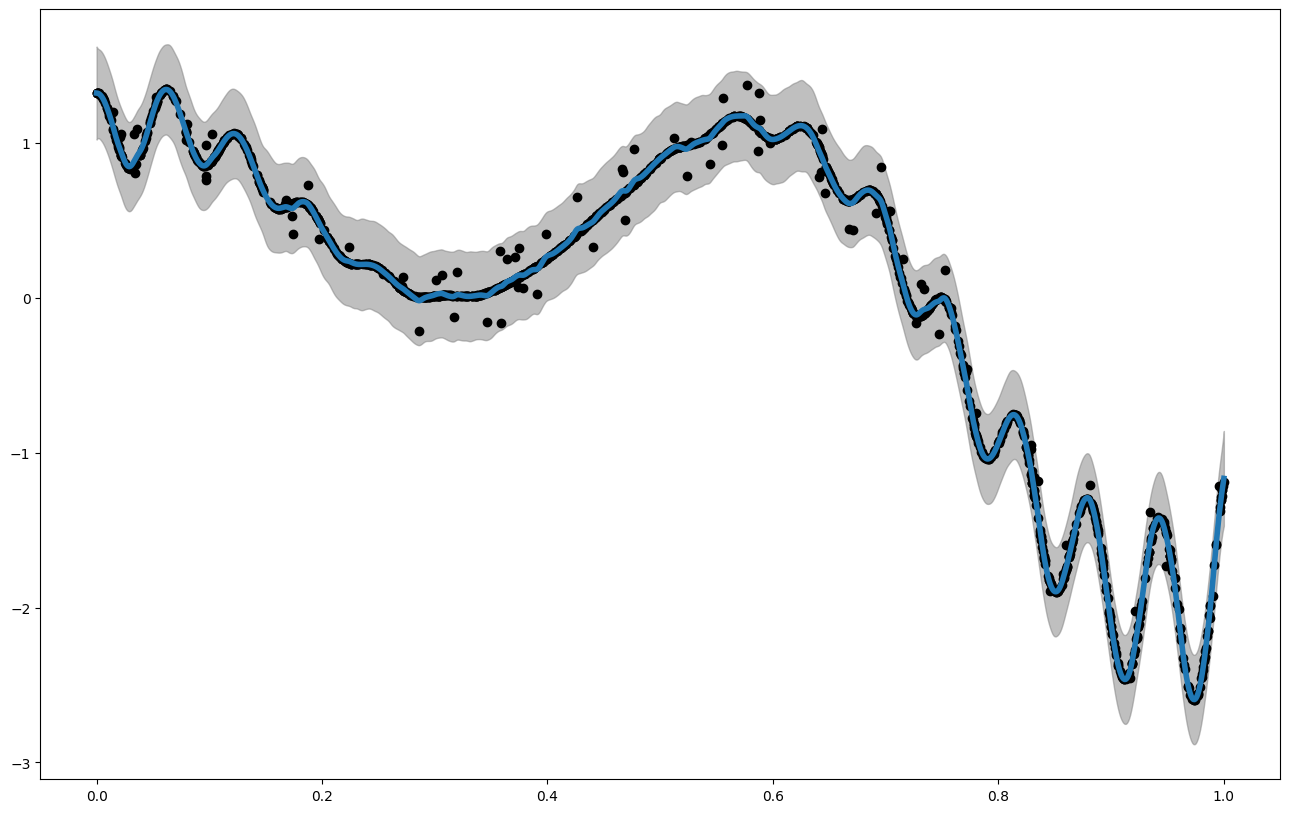

In [143]:
x_pred = np.linspace(0,1,1000)

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
#plt.plot(x_pred,f1(x), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
#plt.plot(x, (f(x)-mean1)**2)
plt.scatter(my_gp1.x_data,my_gp1.y_data, color = 'black')

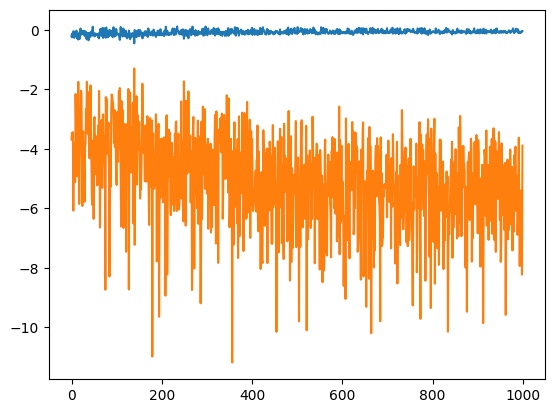

In [144]:
plt.plot(res[:,0])
plt.plot(res[:,1])

In [ ]:
my_gp1.stop_training(opt_obj)
my_gp1.kill_training(opt_obj)

In [ ]:
input_dim = 1
N = 10000
x_data = np.random.rand(N,input_dim)
y_data = f1(x_data)
hps_n = 2

hps_bounds = np.array([[0.1,10.],    ##signal var of stat kernel
                        [0.001,0.02]     ##length scale for stat kernel
                                ])

init_hps = np.random.uniform(size = len(hps_bounds), low = hps_bounds[:,0], high = hps_bounds[:,1])
my_gp2S = GP(1, x_data,y_data,init_hps,  
            gp2Scale = True, gp2Scale_batch_size= 1000
            )



my_gp2S.train(hps_bounds, max_iter = 20, init_hyperparameters = init_hps)
       

In [ ]:
print(my_gp2S.V)


x_pred = np.linspace(0,1,1000)

mean1 = my_gp2S.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp2S.posterior_covariance(x_pred.reshape(-1,1), variance_only=False)["v(x)"]


plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred,f1(x_pred), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')


## Multi Task

In [ ]:
from fvgp.fvgp import fvGP

x = np.linspace(0,1,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)

def f2(x):
    return np.sin(5. * x) + np.cos(2. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)

x_data = np.random.rand(100)
y_data = np.empty((len(x_data),2))
y_data[:,0] = f1(x_data) + (np.random.rand(len(x_data))-0.5) * 0.5
y_data[:,1] = f2(x_data) + (np.random.rand(len(x_data))-0.5) * 0.5
plt.figure(figsize = (15,5))
plt.plot(x,f1(x), color = 'orange', label = 'task1')
plt.plot(x,f2(x), color = 'green',  label = 'task2')
plt.legend()
plt.scatter(x_data,y_data[:,0], s = 20)
plt.scatter(x_data,y_data[:,1], s = 20)

my_gp2 = fvGP(1, 1, 2, x_data,y_data,np.ones((4)),
            noise_variances=None, 
            compute_device='cpu', 
            gp_kernel_function=None, 
            gp_kernel_function_grad=None, 
            gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            gp_noise_function=None,
            normalize_y=False,
            sparse_mode=False,
            store_inv=True, 
            ram_economy=False, 
            args=None,
            )


print("Data Plot:")
plt.scatter(my_gp1.x_data,my_gp1.y_data, s = 20)
plt.show()
x_pred = np.linspace(0,1,1000)


hps_bounds = np.array([[0.001,10.],[0.001,10.],[0.001,10.],[0.001,10.]])

#my_gp1.update_gp_data(x_data, y_data)
print("Global Training")
my_gp2.train(my_gp2.hps_bounds, method='global')
#print("hps: ", my_gp1.get_hyperparameters())
#print("Local Training")
#my_gp1.train(hps_bounds, method='local')
#print(my_gp1.get_hyperparameters())
#print("MCMC Training")
#my_gp1.train(hps_bounds, method='mcmc', max_iter=1000)
#print(my_gp1.get_hyperparameters())

In [ ]:
my_gp2.input_space_dim


In [ ]:
#let's make a prediction
res = my_gp2.posterior_mean(x_pred.reshape(-1,1), x_out=np.array([[0],[1]]), hyperparameters=np.array([1,1,1,1]))
mean2 = res["f(x)"][0:1000]
var2 =  my_gp2.posterior_covariance(x_pred.reshape(-1,1), x_out=np.array([[0],[1]]))["v(x)"][0:1000]

plt.figure(figsize = (16,10))
plt.plot(x,mean2, label = "posterior mean", linewidth = 4)
plt.plot(x,f1(x), label = "latent function", linewidth = 4)
plt.fill_between(x, mean2 - 3. * np.sqrt(var2), mean2 + 3. * np.sqrt(var2), alpha = 0.5, color = "grey", label = "var")
#plt.plot(x, (f(x)-mean1)**2)
plt.scatter(x_data,y_data[:,0], color = 'black')
#plt.legend(fontsize = 20)
plt.xticks([])
plt.yticks([])
print("error: ", np.sum(f1(x)-mean1)**2 / len(mean1))

# Performance Tests